In [117]:
try:
    import river
except Exception:
    import sys
    !{sys.executable} -m pip install river -q
    import importlib
    importlib.invalidate_caches()

# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

# ML libraries
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# River (online learning)
from river import linear_model as r_linear
from river import preprocessing as r_preproc
from river import metrics as r_metrics
from river import optim


In [119]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")

In [121]:
df = pd.read_csv(r"C:\Users\druth\OneDrive\Desktop\5th SEM\CN\project\5G_energy_consumption_dataset.csv\5G_energy_consumption_dataset.csv")

In [123]:
print(df.columns)

Index(['Time', 'BS', 'Energy', 'load', 'ESMODE', 'TXpower'], dtype='object')


In [125]:
print(df.head())


              Time   BS     Energy      load  ESMODE   TXpower
0  20230101 010000  B_0  64.275037  0.487936     0.0  7.101719
1  20230101 020000  B_0  55.904335  0.344468     0.0  7.101719
2  20230101 030000  B_0  57.698057  0.193766     0.0  7.101719
3  20230101 040000  B_0  55.156951  0.222383     0.0  7.101719
4  20230101 050000  B_0  56.053812  0.175436     0.0  7.101719


In [127]:
df.describe()

,Energy,load,ESMODE,TXpower
count,92629.000000,92629.000000,92629.000000,92629.000000
mean,28.138997,0.244705,0.081361,6.765427
std,13.934645,0.234677,0.382317,0.309929
min,0.747384,0.000000,0.000000,5.381166
25%,18.236173,0.057370,0.000000,6.427504
50%,24.065770,0.165550,0.000000,6.875934
75%,35.724963,0.363766,0.000000,6.875934
max,100.000000,0.993957,4.000000,8.375336


In [129]:
print(df.isnull().sum())

Time       0
BS         0
Energy     0
load       0
ESMODE     0
TXpower    0
dtype: int64


In [131]:
df = df.dropna().drop_duplicates().reset_index(drop=True)

In [133]:
print("After cleaning:", df.shape)

After cleaning: (92629, 6)


In [135]:
if 'Time' in df.columns:
    df['Time'] = pd.to_datetime(df['Time'], errors='coerce')
    df['hour'] = df['Time'].dt.hour.fillna(0).astype(int)
    df['day'] = df['Time'].dt.day.fillna(0).astype(int)
    df['weekday'] = df['Time'].dt.weekday.fillna(0).astype(int)
else:
    df['hour'] = df.get('hour', 0).astype(int)
    df['day'] = df.get('day', 0).astype(int)
    df['weekday'] = df.get('weekday', 0).astype(int)

# Derived features
df['load_tx_interaction'] = df['load'] * df['TXpower']
df['EEI'] = df['Energy'] / (df['load'] + 1e-5)
clip_upper = df['EEI'].quantile(0.999)
df['EEI_clipped'] = df['EEI'].clip(upper=clip_upper)

In [137]:
iqr_k = 1.5
cols_for_outlier_detection = ['Energy', 'load', 'TXpower', 'EEI_clipped']
drop_zero_or_negative_load = True   # remove rows with load <= 0 to avoid inflated EEI

df_pre = df.copy()

# Remove rows with non-positive load if requested (they create EEI instability)
if drop_zero_or_negative_load:
    before_rows = len(df_pre)
    df_pre = df_pre[df_pre['load'] > 0].reset_index(drop=True)
    removed = before_rows - len(df_pre)
    print(f"Removed {removed} rows with load <= 0 (to avoid inflated EEI)")

# IQR-based outlier removal (applied across selected columns)
def iqr_bounds(series, k=1.5):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - k * iqr
    upper = q3 + k * iqr
    return lower, upper


Removed 29 rows with load <= 0 (to avoid inflated EEI)


In [139]:
keep_mask = pd.Series(True, index=df_pre.index)

for col in cols_for_outlier_detection:
    if col not in df_pre.columns:
        print(f"Warning: {col} not in df_pre columns; skipping")
        continue
    lower, upper = iqr_bounds(df_pre[col], k=iqr_k)
    col_mask = (df_pre[col] >= lower) & (df_pre[col] <= upper)
    removed_count = (~col_mask).sum()
    print(f"{col}: IQR bounds -> lower={lower:.4g}, upper={upper:.4g}, will remove {removed_count} rows")
    keep_mask &= col_mask


Energy: IQR bounds -> lower=-7.997, upper=61.96, will remove 2192 rows
load: IQR bounds -> lower=-0.4021, upper=0.8234, will remove 2974 rows
TXpower: IQR bounds -> lower=5.755, upper=7.549, will remove 1162 rows
EEI_clipped: IQR bounds -> lower=-334.8, upper=781.1, will remove 10297 rows


In [141]:
# Apply combined mask
before_total = len(df_pre)
df_clean = df_pre.loc[keep_mask].reset_index(drop=True)
after_total = len(df_clean)
removed_total = before_total - after_total
pct_removed = removed_total / before_total * 100.0
print(f"\nTotal rows removed by combined IQR filter: {removed_total} / {before_total} ({pct_removed:.2f}%)")
print(f"Cleaned dataframe shape: {df_clean.shape}")


Total rows removed by combined IQR filter: 15829 / 92600 (17.09%)
Cleaned dataframe shape: (76771, 12)


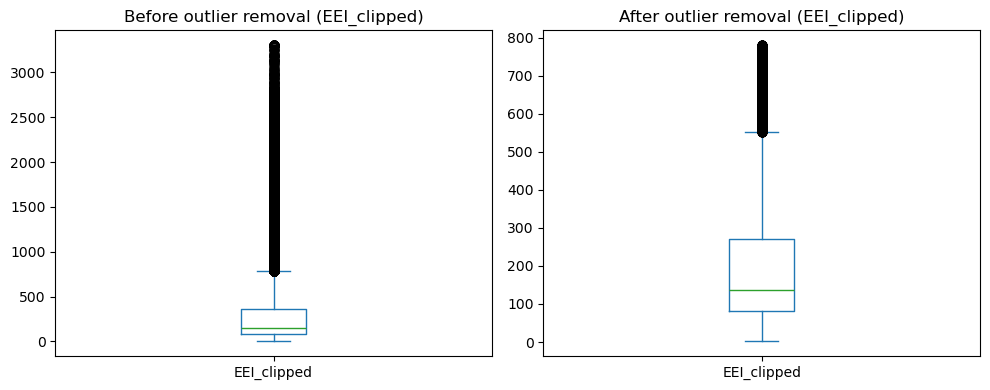

In [143]:
try:
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    df_pre['EEI_clipped'].plot.box()
    plt.title('Before outlier removal (EEI_clipped)')
    plt.subplot(1,2,2)
    df_clean['EEI_clipped'].plot.box()
    plt.title('After outlier removal (EEI_clipped)')
    plt.tight_layout(); plt.show()
except Exception as e:
    print("Boxplot visualization failed:", e)

In [145]:
df = df_clean.copy()

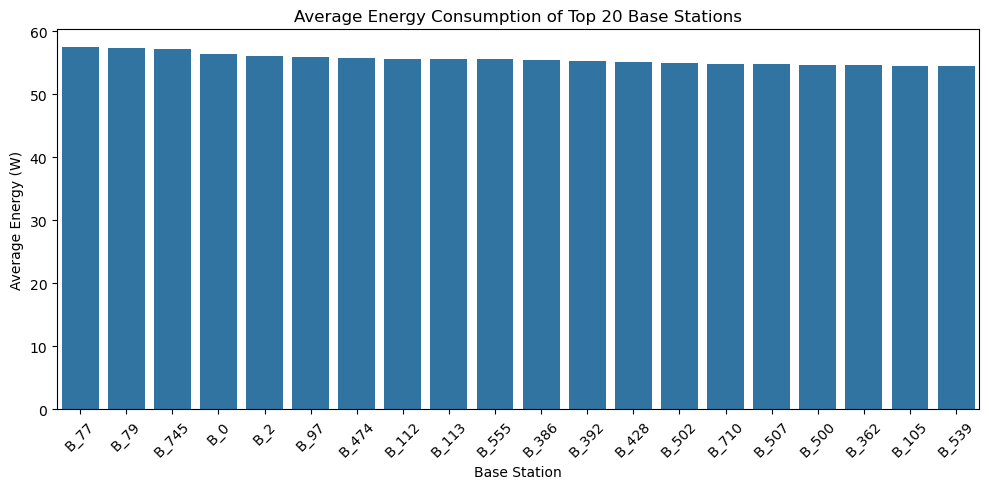

In [147]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
avg_energy = df.groupby('BS')['Energy'].mean().reset_index()
sns.barplot(x='BS', y='Energy', data=avg_energy.sort_values('Energy', ascending=False).head(20))
plt.title('Average Energy Consumption of Top 20 Base Stations')
plt.xlabel('Base Station')
plt.ylabel('Average Energy (W)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


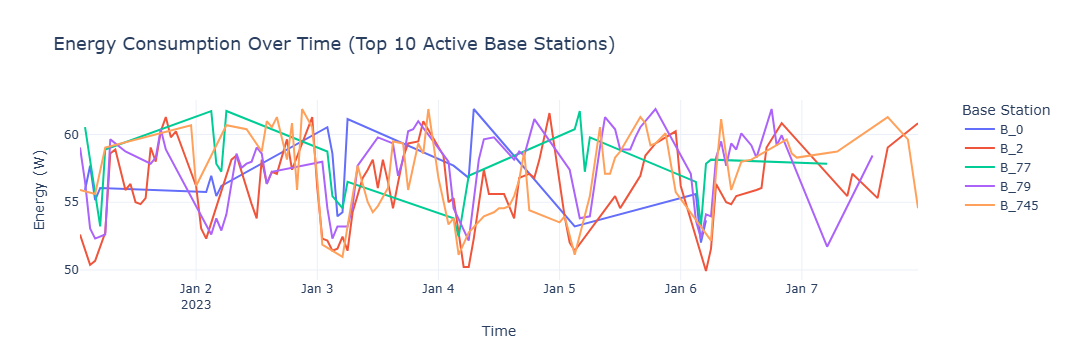

In [149]:
import plotly.express as px
top_bs = df.groupby('BS')['Energy'].mean().nlargest(5).index
subset = df[df['BS'].isin(top_bs)]

# Create interactive line chart
fig = px.line(
    subset,
    x='Time',
    y='Energy',
    color='BS',
    title='Energy Consumption Over Time (Top 10 Active Base Stations)',
    labels={
        'Time': 'Time',
        'Energy': 'Energy (W)',
        'BS': 'Base Station'
    },
    template='plotly_white'
)

# Optional styling
fig.update_layout(
    legend_title_text='Base Station',
    legend=dict(
        orientation="v",
        yanchor="top",
        y=1.02,
        xanchor="left",
        x=1.05
    ),
    title_font=dict(size=18),
    font=dict(size=12)
)


fig.show()


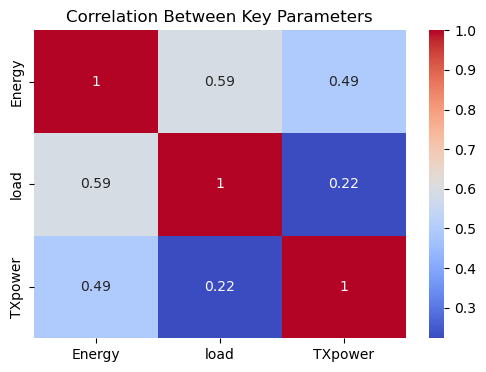

In [151]:
import seaborn as sns
plt.figure(figsize=(6,4))
sns.heatmap(df[['Energy','load','TXpower']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Between Key Parameters')
plt.show()


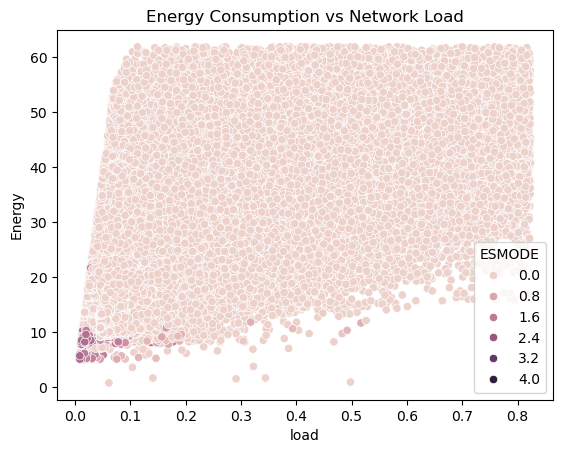

In [153]:
sns.scatterplot(x='load', y='Energy', hue='ESMODE', data=df)
plt.title('Energy Consumption vs Network Load')
plt.show()


In [155]:
feature_cols = ['load', 'TXpower', 'ESMODE', 'hour', 'load_tx_interaction']
X = df[feature_cols].copy()
y = df['EEI_clipped'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
df_test = df.loc[X_test.index].copy().reset_index(drop=True)

In [157]:
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

In [159]:
lgb_eei = LGBMRegressor(
    objective='regression',
    n_estimators=300,
    learning_rate=0.05,
    num_leaves=31,
    random_state=42
)
lgb_eei.fit(X_train_s, y_train, eval_set=[(X_test_s, y_test)], eval_metric='rmse')

# Predictions
y_pred_eei = lgb_eei.predict(X_test_s)
df_test['Predicted_EEI'] = y_pred_eei
df_test['Predicted_Energy_from_EEI'] = df_test['Predicted_EEI'] * (df_test['load'] + 1e-5)

# Metrics
def rmse(a, b): return math.sqrt(mean_squared_error(a, b))
print(f"\nLightGBM EEI on cleaned data -- MAE: {mean_absolute_error(y_test, y_pred_eei):.4f}, "
      f"RMSE: {rmse(y_test, y_pred_eei):.4f}, R2: {r2_score(y_test, y_pred_eei):.4f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000704 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 824
[LightGBM] [Info] Number of data points in the train set: 61416, number of used features: 5
[LightGBM] [Info] Start training from score 206.354168

LightGBM EEI on cleaned data -- MAE: 26.0926, RMSE: 44.0253, R2: 0.9356


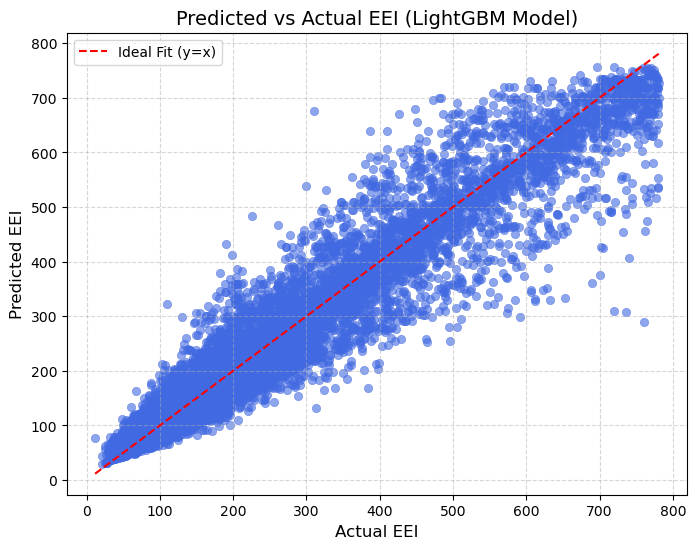

In [175]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_eei, alpha=0.6, color="royalblue", edgecolor=None)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Ideal Fit (y=x)")
plt.xlabel("Actual EEI", fontsize=12)
plt.ylabel("Predicted EEI", fontsize=12)
plt.title("Predicted vs Actual EEI (LightGBM Model)", fontsize=14)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

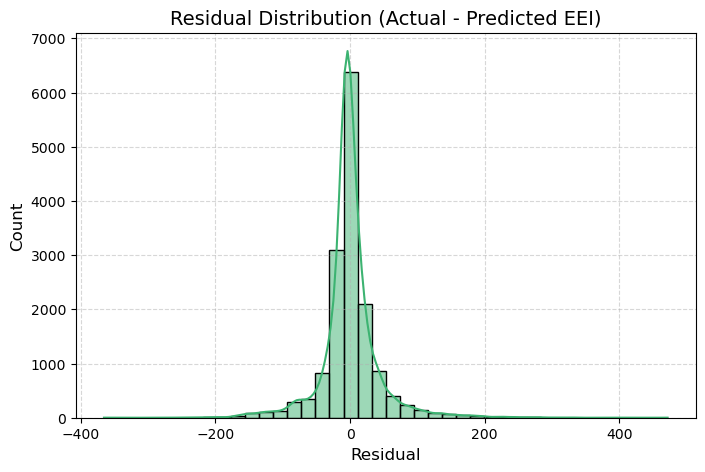

In [177]:
residuals = y_test - y_pred_eei
plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True, color="mediumseagreen", bins=40)
plt.title("Residual Distribution (Actual - Predicted EEI)", fontsize=14)
plt.xlabel("Residual", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

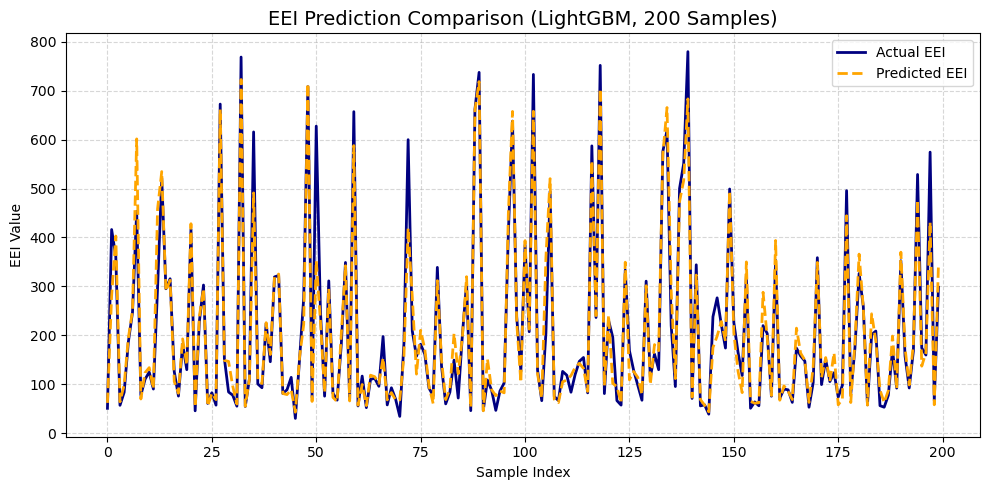

In [193]:
# Actual vs Predicted line comparison (limited to 200 samples for clarity)
df_pred = pd.DataFrame({
    'Actual EEI': y_test.reset_index(drop=True),
    'Predicted EEI': y_pred_eei
}).reset_index()

# Option 1: First 200 samples (ordered)
df_pred_subset = df_pred.iloc[:200]

# Option 2 (alternative): Random 200 samples
# df_pred_subset = df_pred.sample(200, random_state=42).sort_index()

plt.figure(figsize=(10, 5))
plt.plot(df_pred_subset['index'], df_pred_subset['Actual EEI'], label='Actual EEI', color='navy', linewidth=2)
plt.plot(df_pred_subset['index'], df_pred_subset['Predicted EEI'], label='Predicted EEI', color='orange', linestyle='--', linewidth=2)
plt.title("EEI Prediction Comparison (LightGBM, 200 Samples)", fontsize=14)
plt.xlabel("Sample Index")
plt.ylabel("EEI Value")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


C:\Users\druth\AppData\Local\Temp\ipykernel_11064\1769984324.py:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




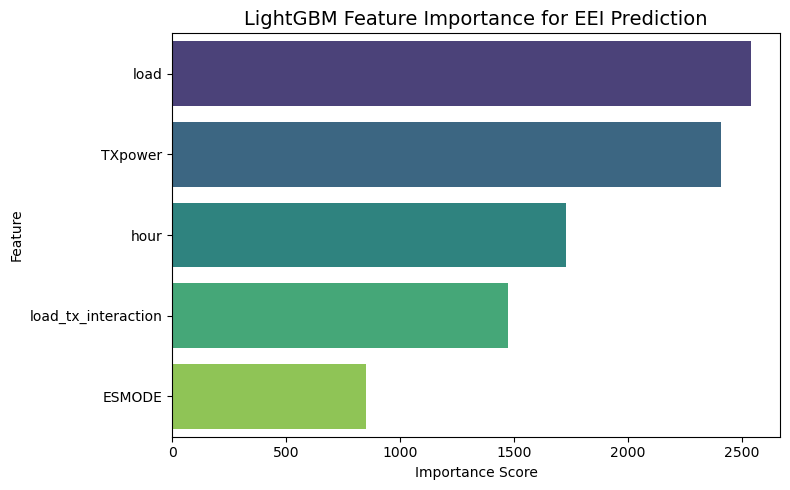


Feature Importance (sorted):
               Feature  Importance
0                 load        2539
1              TXpower        2408
3                 hour        1727
4  load_tx_interaction        1475
2               ESMODE         851


In [195]:

importances = lgb_eei.feature_importances_
feature_names = X_train.columns

# Create a DataFrame
feat_imp = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp = feat_imp.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x='Importance', y='Feature', data=feat_imp, palette='viridis')
plt.title('LightGBM Feature Importance for EEI Prediction', fontsize=14)
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Optional: print numerical values
print("\nFeature Importance (sorted):")
print(feat_imp)


In [161]:
y_train_pred = lgb_eei.predict(X_train_s)
cal = LinearRegression().fit(y_train_pred.reshape(-1, 1), y_train.values.reshape(-1, 1))

# Calibrate the test predictions (vectorized) and store
y_pred_eei_cal = cal.predict(y_pred_eei.reshape(-1, 1)).ravel()
df_test['Predicted_EEI_Cal'] = y_pred_eei_cal
df_test['Predicted_Energy_from_EEI_Cal'] = df_test['Predicted_EEI_Cal'] * (df_test['load'] + 1e-5)
print(f"After calibration EEI MAE: {mean_absolute_error(y_test, y_pred_eei_cal):.4f}")

After calibration EEI MAE: 26.0679


In [163]:
online_model = r_preproc.StandardScaler() | r_linear.LinearRegression(optimizer=optim.SGD(0.01))
online_metric = r_metrics.MAE()

df_stream = df_test.reset_index().copy()
df_stream['EEI_Pred_OnlineCorrected'] = df_stream['Predicted_EEI_Cal']
df_stream['Energy_Pred_OnlineCorrected'] = df_stream['Predicted_Energy_from_EEI_Cal']

# Online loop: predict residual and learn
for i, row in df_stream.iterrows():
    x_row = {k: float(row[k]) for k in feature_cols}
    base_pred = float(row['Predicted_EEI_Cal'])
    res_pred = online_model.predict_one(x_row) or 0.0
    eei_corrected = base_pred + res_pred
    df_stream.at[i, 'EEI_Pred_OnlineCorrected'] = eei_corrected
    df_stream.at[i, 'Energy_Pred_OnlineCorrected'] = eei_corrected * (row['load'] + 1e-5)
    true_residual = float(row['EEI']) - base_pred
    online_model.learn_one(x_row, true_residual)
    online_metric.update(true_residual, res_pred)

print(f"Online residual MAE on residuals: {online_metric.get():.4f}")

Online residual MAE on residuals: 29.3038


In [165]:
df_test['EEI_Pred_OnlineCorrected'] = df_stream.set_index('index')['EEI_Pred_OnlineCorrected']
df_test['Energy_Pred_OnlineCorrected'] = df_stream.set_index('index')['Energy_Pred_OnlineCorrected']

In [167]:
pred_col = 'EEI_Pred_OnlineCorrected'
if pred_col not in df_test.columns:
    df_test[pred_col] = df_stream.set_index('index')[pred_col]

high_threshold = df_test[pred_col].quantile(0.80)
low_threshold  = df_test[pred_col].quantile(0.20)


In [169]:
min_factor = 0.90
max_factor = 1.10

df_policy = df_test.copy()
df_policy['TXpower_opt'] = df_policy['TXpower']

In [171]:
# Base EEI (calibrated) vector
if 'Predicted_EEI_Cal' in df_policy.columns:
    base_eei_cal_arr = df_policy['Predicted_EEI_Cal'].values
else:
    base_eei_cal_arr = cal.predict(df_policy['Predicted_EEI'].values.reshape(-1, 1)).ravel()

In [173]:
# Compute online residuals for the original rows
res_preds_orig = []
for _, row in df_policy[feature_cols].iterrows():
    x_row = {k: float(row[k]) for k in feature_cols}
    r = online_model.predict_one(x_row)
    res_preds_orig.append(float(r) if r is not None else 0.0)
res_preds_orig = np.array(res_preds_orig)

eei_corrected_current_arr = base_eei_cal_arr + res_preds_orig

In [179]:
den_high = max(df_policy[pred_col].max() - high_threshold, 1e-9)
den_low  = max(low_threshold - df_policy[pred_col].min(), 1e-9)

# compute fractions
frac_reduce = np.clip((eei_corrected_current_arr - high_threshold) / den_high, 0.0, 0.2)
frac_reduce = np.where(eei_corrected_current_arr > high_threshold, np.maximum(frac_reduce, 0.01), 0.0)

frac_increase = np.clip((low_threshold - eei_corrected_current_arr) / den_low, 0.0, 0.05)
frac_increase = np.where(eei_corrected_current_arr < low_threshold, np.maximum(frac_increase, 0.01), 0.0)

# default factor = 1.0; apply reductions/increases
factor_arr = np.ones_like(eei_corrected_current_arr)
factor_arr = np.where(eei_corrected_current_arr > high_threshold, 1.0 - frac_reduce, factor_arr)
factor_arr = np.where(eei_corrected_current_arr < low_threshold, 1.0 + frac_increase, factor_arr)

# clamp
factor_arr = np.clip(factor_arr, min_factor, max_factor)


In [181]:
# apply TXpower_opt
df_policy['TXpower_opt'] = df_policy['TXpower'] * factor_arr

# Recompute interaction and features for the policy scenario
df_policy['load_tx_interaction'] = df_policy['load'] * df_policy['TXpower_opt']
X_opt = df_policy[feature_cols].copy()
X_opt['TXpower'] = df_policy['TXpower_opt']
X_opt_s = scaler.transform(X_opt)

# Predictions with LGBM (on optimized TXpower features)
pred_eei_opt = lgb_eei.predict(X_opt_s)
pred_eei_opt_cal = cal.predict(pred_eei_opt.reshape(-1, 1)).ravel()

# Recompute online residuals on the policy features
res_preds_opt = []
for _, row in X_opt.iterrows():
    x_row = {k: float(row[k]) for k in feature_cols}
    r = online_model.predict_one(x_row)
    res_preds_opt.append(float(r) if r is not None else 0.0)
res_preds_opt = np.array(res_preds_opt)

In [183]:
# Final EEI under policy = LGBM_pred (calibrated) + online_residual(policy features)
eei_policy_final = pred_eei_opt_cal + res_preds_opt
df_policy['Pred_EEI_policy'] = eei_policy_final
df_policy['Pred_Energy_policy'] = df_policy['Pred_EEI_policy'] * (df_policy['load'] + 1e-5)

# Evaluate policy safely (avoid tiny Energy values)
safe_mask = df_policy['Energy'] > 1e-6
opt_pct = ((df_policy.loc[safe_mask, 'Energy'] - df_policy.loc[safe_mask, 'Pred_Energy_policy']) 
           / df_policy.loc[safe_mask, 'Energy']).mean() * 100
opt_pct = abs(opt_pct)
improved_frac = (df_policy.loc[safe_mask, 'Pred_Energy_policy'] < df_policy.loc[safe_mask, 'Energy']).mean() * 100

print("\nCorrected policy results (after preprocessing outlier removal):")
print(f"Average Predicted Energy Optimization: {opt_pct:.3f}%")
print(f"Improved sample fraction: {improved_frac:.2f}%")


Corrected policy results (after preprocessing outlier removal):
Average Predicted Energy Optimization: 10.707%
Improved sample fraction: 41.59%


In [191]:
print("\nSample TXpower changes (first 8 rows):")
print(df_policy[['TXpower', 'TXpower_opt', 'EEI', 'Predicted_EEI_Cal', 'EEI_Pred_OnlineCorrected']].tail(8))

frac_change = df_policy['TXpower_opt'] / df_policy['TXpower'] - 1.0
print("\nTXpower change fraction summary:")
print(frac_change.describe())




Sample TXpower changes (first 8 rows):
        TXpower  TXpower_opt         EEI  Predicted_EEI_Cal  \
15347  5.949178     5.949178  206.415280         204.300428   
15348  6.427504     6.363229  336.696223         321.790911   
15349  6.427504     6.427504  254.098683         167.825964   
15350  6.427504     6.139918  611.520298         617.481127   
15351  6.875934     6.875934  139.688513         138.497092   
15352  7.100897     7.100897  302.931785         292.637603   
15353  6.875934     6.602770  455.002755         583.368460   
15354  6.875934     6.875934  188.889998         197.501118   

       EEI_Pred_OnlineCorrected  
15347                162.086000  
15348                310.886170  
15349                159.189299  
15350                604.450701  
15351                146.026846  
15352                289.599291  
15353                576.636812  
15354                181.491065  

TXpower change fraction summary:
count    15355.000000
mean        -0.001334
std     

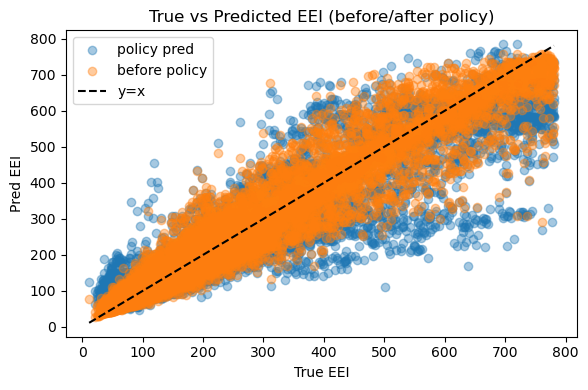

In [189]:
# Quick plots: True vs Predicted EEI and Energy (before vs after policy)
try:
    plt.figure(figsize=(6,4))
    plt.scatter(df_policy['EEI'], df_policy['Pred_EEI_policy'], alpha=0.4, label='policy pred')
    plt.scatter(df_policy['EEI'], df_policy['Predicted_EEI_Cal'], alpha=0.4, label='before policy')
    plt.plot([df_policy['EEI'].min(), df_policy['EEI'].max()],
             [df_policy['EEI'].min(), df_policy['EEI'].max()],
             '--', label='y=x', color='k')
    plt.legend(); plt.xlabel('True EEI'); plt.ylabel('Pred EEI'); plt.title('True vs Predicted EEI (before/after policy)')
    plt.tight_layout(); plt.show()
except Exception as e:
    print("Plot failed:", e)